Importing necessary libraries

In [1]:
import gizmo_analysis as gizmo
import utilities as ut
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import optimize
import glob
import math

Setting text properties for plots

In [2]:
plt.rcParams.update({'font.size': 16.5})
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.close()

Necessary functions

In [3]:
def num_PDF(values, weights, left, right, bin_size, norm):
    
    bins = np.arange(left, right, bin_size)
    heights, edges = np.histogram(values, bins, weights = weights)
    centers = 0.5*(edges[1:] + edges[:-1])
    heights = heights/(bin_size*norm)

    return centers, heights

In [4]:
def fit_error(y, f):
    return np.sum((y-f)**2)

In [5]:
def fit_func_1(Z, A, mu, sigma):
    
    P = (A/np.sqrt(2*np.pi*sigma**2))*np.exp(-((Z-mu)**2/(2*sigma**2)))
    
    return P

In [6]:
def fit_func_2(Z, A, mu, sigma, alpha, z_T):
    
    B = (A*np.exp(alpha*z_T))/np.sqrt(2*np.pi*sigma**2)*np.exp(-(z_T-mu)**2/(2*sigma**2))
    
    Z_1 = Z[np.where(Z <= z_T)]
    Z_2 = Z[np.where(Z > z_T)]
    
    P_1 = (A/np.sqrt(2*np.pi*sigma**2))*np.exp(-((Z_1 - mu)**2/(2*sigma**2)))
    P_2 = B*np.exp(-alpha*Z_2)

    P = np.concatenate([P_1, P_2])
    
    return P

In [7]:
def fit_PDF(centers, heights):
            
    fit = np.zeros(len(centers))
    fit_err = 0
    fit_params = np.zeros(5)

    # If all bins are empty
    if (np.all(heights == 0)):
        fit_params = np.array([0, float('nan'), float('nan'), float('nan'), float('nan')])
    
    # Otherwise
    else:
        
        # Information about the peak in the numerical PDF
        peak_ind = np.where(heights == np.max(heights))[0][0]
        peak_height = np.max(heights)
        
        # mu is where the numerical PDF peaks
        mu = centers[peak_ind]
        
        # Estimating sigma using FWHM
        sigma = 0
        
        for i in range(0, peak_ind):
            if(heights[i] >= peak_height/2):
                sigma = (mu - centers[i])/np.sqrt(2*np.log(2))
                break
          
        # Estimating A accordingly, by using the peak value at mu
        A = np.sqrt(2*np.pi*sigma**2)*peak_height
        
        # First fit a Gaussian
            
        guess_params = np.array([A, mu, sigma])
        fit_params, fit_covar = optimize.curve_fit(fit_func_1, centers, heights, p0=guess_params)
        fit = fit_func_1(centers, *fit_params)
        fit_err = fit_error(heights, fit)
        fit_params = np.concatenate([fit_params, np.array([float('nan'), float('nan')])])
                
        prev_err = fit_err
        
        # See if an exponential decay tail exists and is a better fit
        
        try:
        
            for i in range(peak_ind, len(centers)):
            
                v_T = centers[i] 
                init_height = heights[i]
            
                # Estimating alpha using half-life decay
                alpha = 0
        
                for j in range(i+1, len(centers)):
                    if(heights[j] <= init_height/2):
                        alpha = np.log(2)/(centers[j]-v_T)
                        break
            
                curr_guess_params = np.array([A, mu, sigma, alpha])
            
                curr_fit_params, curr_fit_covar = optimize.curve_fit(
                            lambda centers, A, mu, sigma, alpha: fit_func_2(centers, A, mu, sigma, alpha, v_T)
                                , centers, heights, p0=curr_guess_params, method = 'dogbox', maxfev = 5000)
            
                curr_fit = fit_func_2(centers, *curr_fit_params, v_T)
                curr_err = fit_error(heights, curr_fit)

                if(curr_err < prev_err):
                    fit = curr_fit
                    fit_err = curr_err
                    fit_params = np.concatenate([curr_fit_params, np.array([v_T])])
                
                prev_err = curr_err

        except:
            pass
        
    return fit, fit_params

In [8]:
def select_phase(temperatures, radii, phase_num):
    
    select_phase = np.zeros(len(temperatures), dtype = bool)
    
    # ISM
    if(phase_num == 0):
        select_phase = radii < 0.1*r_vir
        
    # HIM 
    elif(phase_num == 1):
        select_phase = np.all([(radii < 0.1*r_vir), (temperatures >= 10**5.5)], axis = 0)
    
    # WIM
    elif(phase_num == 2):
        select_phase = np.all([(radii < 0.1*r_vir), (temperatures >= 10**4), (temperatures < 10**5.5)], axis = 0)
        
    #WNM
    elif(phase_num == 3):
        select_phase = np.all([(radii < 0.1*r_vir), (temperatures >= 10**3), (temperatures < 10**4)], axis = 0)
        
    #CNM
    elif(phase_num == 4):
        select_phase = np.all([(radii < 0.1*r_vir), (temperatures < 10**3)], axis = 0)

    return select_phase

In [9]:
# Specifying simulation directory and the directory to save results in

wdir = str(input('Enter simulation directory path: '))
sdir = wdir + str(input('Enter path of storage directory relative to simulation directory: '))

Enter simulation directory path: /Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/
Enter path of storage directory relative to simulation directory: files/time_evol/fe_WIM/


In [10]:
# Finding all available snapshot indices

path_list = glob.glob(wdir +'output/snap*')
file_list = [path.replace(wdir + 'output/snapshot_', '') for path in path_list]
file_list = [file.replace(wdir + 'output/snapdir_', '') for file in file_list]
snap_list = [path.replace('.hdf5', '') for path in  file_list]
snap_indices = np.array(np.sort([int(snap) for snap in snap_list]))

In [11]:
# Select metal
metal = str(input('Which metal do you wish to study? (enter chemical symbol in lowercase): '))

# Select phase
phase_index = int(input('Which phase do you want to study? (ISM: 0, HIM: 1, WIM: 2, WNM: 3, CNM: 4): '))

# Create a dictionary linking phases to numbers
phases = {0: 'ISM', 1: 'HIM', 2: 'WIM', 3: 'WNM', 4: 'CNM'}

phase = phases[phase_index]

# Creating the fit_info file

file_name = 'fit_info_' + metal + '_' + phase + '.txt'

info = open(sdir + file_name, 'w')
info.write('Evolution Information \n \n')

info.write('Metal: ' + metal + '\n')
info.write('Phase: ' + phase + '\n \n')

info.close()

Which metal do you wish to study? (enter chemical symbol in lowercase): fe
Which phase do you want to study? (ISM: 0, HIM: 1, WIM: 2, WNM: 3, CNM: 4): 2



# in utilities.simulation.Snapshot():
* reading:  Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/snapshot_times.txt

  using snapshot index = 0, redshift = 99.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/output/snapshot_000.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 260408 particles
    dark2     (id = 2): 2281573 particles
    gas       (id = 0): 260408 particles
    star      (id = 4): 0 particles
    blackhole (id = 5): 0 particles

* reading species: ['gas', 'dark']
* reading particles from:
    Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/output/snapshot_000.hdf5

! cannot find MUSIC config file:  Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA box):
  assuming omega_bary

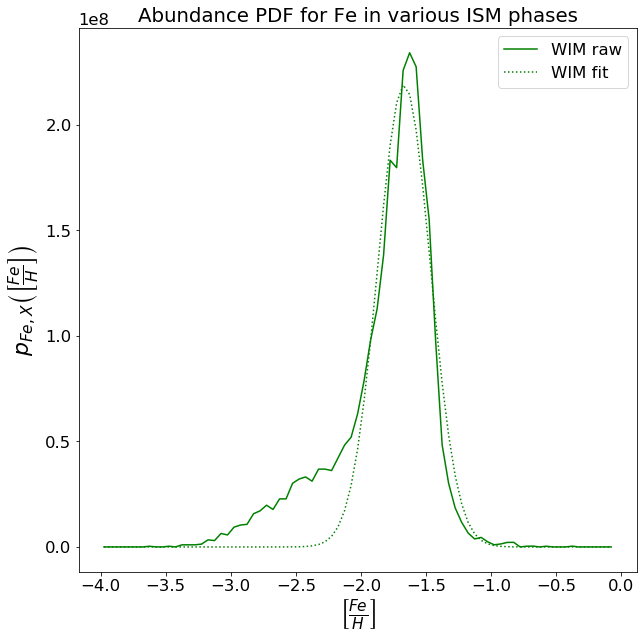

In [16]:
# Create PDFs for all snapshots

info = open(sdir + file_name,'a')

info.write('Info array can be of the following forms \n \n') 
info.write('1. Empty phase - [0, nan, nan, nan, nan] \n')
info.write('2. Pure Gaussian - [A, mu, sigma, nan, nan] \n')
info.write('3. Gaussian + exp. decay - [A, mu, sigma, alpha, z_T] \n \n')

for snap_index in snap_indices:
    
    try:
        # Importing data from the snapshot
        part = gizmo.io.Read.read_snapshots(['star','gas', 'dark'], 'index', snap_index, assign_hosts_rotation = True, 
            simulation_directory = wdir)
    
        # Getting halo properties
        halo_properties = ut.particle.get_halo_properties(part, 'all')
    
        # Virial radius
        r_vir = halo_properties['radius']

        # Finding radial distance, temperature, number density, and mass of grid cells
        radii = part['gas'].prop('host.distance.principal.spherical')[:,0]
        temperatures = part['gas'].prop('temperature')
        masses = part['gas'].prop('mass')
    
        # Find grid cells in the selected phase
        select_phase_ind = select_phase(temperatures, radii, phase_index)
        
        # Grid distribution of masses by phase
        mass_phase = masses[select_phase_ind]
    
        # Grid distribution of metal in phase
        abundance_metal_phase = part['gas'].prop('metallicity.' + metal)[select_phase_ind]
    
        # Common bin-size for all numerical PDFs
        bin_size = 0.05
    
        # Generating numerical PDFs and Gaussian + exp decay fits
        mass_norm = np.sum(mass_phase)
        
        fig, ax = plt.subplots(figsize = (10, 10))
        
        left = np.floor(np.min(abundance_metal_phase))
        right = np.ceil(np.max(abundance_metal_phase))

        # Compute the numerical PDF  
        centers, heights = num_PDF(abundance_metal_phase, mass_phase, left, right, bin_size, mass_norm)

        # Compute the fitted PDF
        fit, fit_params = fit_PDF(centers, heights)
    
        # Rescaling heights to achieve desired normalization       
        heights *= mass_norm
        fit *= mass_norm
        fit_params[0] *= mass_norm

        # Plotting the raw data and the fit
        ax.plot(centers, heights, color = 'g', label = phase + str(' raw'))
        ax.plot(centers, fit, color = 'g', label = phase + str(' fit'), linestyle = ':')
    
        # Labelling the plots
        ax.set_xlabel(r'$\left[ \frac{{{}}}{{H}} \right]$'.format(metal.title()), fontsize = 22)
        ax.set_ylabel(r'$p_{{{0}, X}} \left( \left[ \frac{{{0}}}{{H}} \right] \right)$'.format(metal.title()),
                     fontsize = 22)
        ax.set_title('Abundance PDF for {} in various ISM phases'.format(metal.title()))
        ax.legend() 
    
        # Save the file
        fig.savefig(sdir + '{0}-abundance_{1}_{2}.png'.format(str(snap_index), metal.title(), phase))
        
        # Write to fit_info.txt
        info.write('Snapshot ' + str(snap_index) + ': ')
        info.write('[' + str(fit_params[0]) + ',' + str(fit_params[1]) +
                    ',' + str(fit_params[2]) + ',' + str(fit_params[3])
                        + str(fit_params[4]) + '] \n')
        
         
        print('Completed rendering and writing parameters for snapshot ' + str(snap_index))
        
    
    except:
        info.write('Snapshot ' + str(snap_index) + ': not rendered \n')
        print('Snapshot ' + str(snap_index) + ' could not be rendered')
        
info.close()